In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_, cast, Date

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
print(Measurement.__table__.columns.keys())

['id', 'station', 'date', 'prcp', 'tobs']


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
max_date = session.query(func.max(Measurement.date)).scalar()
print(max_date)

2017-08-23


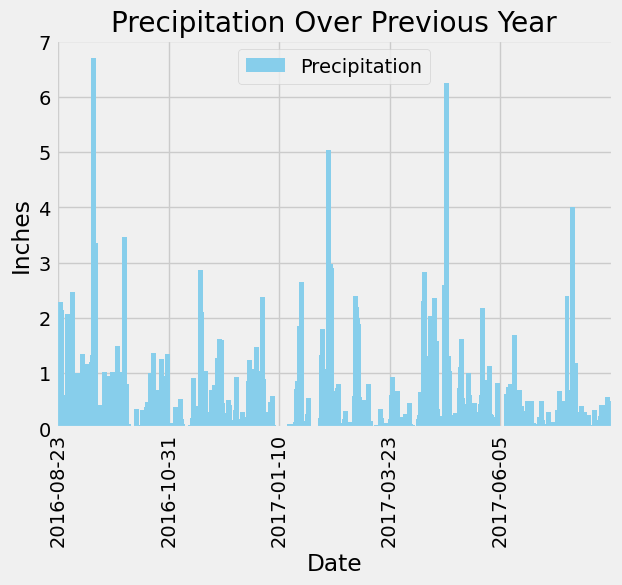

In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
#max_date
# Calculate the date one year from the last date in data set.
twelve_months_previous = session.query(
    func.date(max_date,'-12 months')).scalar()

##print(f"{twelve_months_previous} is the date 12 months before latest date of {max_date}")

# Perform a query to retrieve the data and precipitation scores
precip_data = engine.execute("""SELECT date, prcp FROM measurement WHERE date BETWEEN (SELECT DATE(MAX(date),'-12 months') FROM measurement) 
AND (SELECT MAX(date) FROM measurement)""")

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_precip_data = pd.DataFrame(precip_data, columns=['Observed_Date', 'Precipitation'])

# Sort the dataframe by date
precip_data_date_sort = df_precip_data.sort_values(by='Observed_Date')

# Setting index to be the date for x-axis
precip_data_date_sort.set_index('Observed_Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_data_date_sort['Precipitation'].plot(kind='bar',color='skyblue',width=20)

plt.title('Precipitation Over Previous Year')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='upper center')

#  Adjusting x axis to show fewer dates
plt.locator_params(axis='x', nbins=5)
tick_positions = range(0, len(precip_data_date_sort), len(precip_data_date_sort) // 5)

plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_data_summary = precip_data_date_sort[['Precipitation']]

precip_data_summary.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_data = engine.execute("SELECT COUNT(DISTINCT station) FROM measurement").scalar()
station_data

9

In [49]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = engine.execute("""SELECT station, COUNT(*) as row_count FROM measurement GROUP BY station ORDER BY row_count DESC;""")

for station_activities in station_activity:
    print(f"{station_activities['station']} - {station_activities['row_count']}")

USC00519281 - 2772
USC00519397 - 2724
USC00513117 - 2709
USC00519523 - 2669
USC00516128 - 2612
USC00514830 - 2202
USC00511918 - 1979
USC00517948 - 1372
USC00518838 - 511


In [52]:
print("Top station is USC00519281") 

Top station is USC00519281


In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_281 = engine.execute("""SELECT MAX(tobs) as Max_temp, MIN(tobs) as Min_temp, AVG(tobs) as Avg_temp 
FROM measurement WHERE station = 'USC00519281'""")

station_281_stats = station_281.fetchone()

print(f"Min_Temp: {station_281_stats['Min_temp']}")
print(f"Max_Temp: {station_281_stats['Max_temp']}")
print(f"Avg_Temp: {station_281_stats['Avg_temp']}")


Min_Temp: 54.0
Max_Temp: 85.0
Avg_Temp: 71.66378066378067


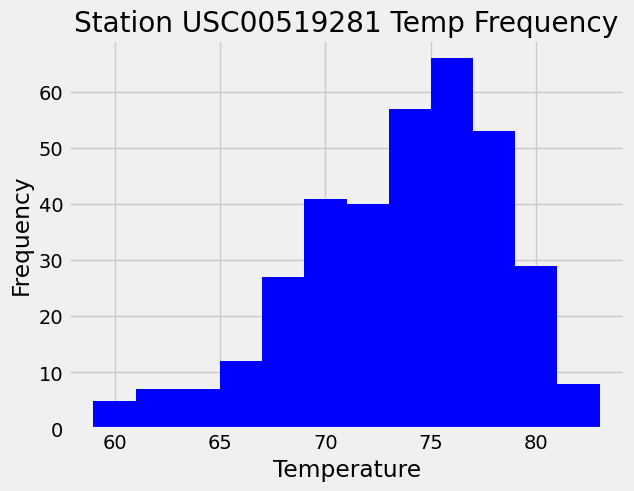

In [44]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_281_temps_last_12 = engine.execute("""SELECT date, tobs FROM measurement 
WHERE station = 'USC00519281'
AND date BETWEEN (SELECT DATE(MAX(date),'-12 months') FROM measurement) 
AND (SELECT MAX(date) FROM measurement)""")

df_station_281_temps_last_12 = pd.DataFrame(station_281_temps_last_12, columns=['Date','Temperature'])

df_station_281_temps_last_12['Temp_Int'] = df_station_281_temps_last_12['Temperature'].astype(int)

plt.hist(df_station_281_temps_last_12['Temp_Int'], bins=12, color='blue')

plt.title('Station USC00519281 Temp Frequency')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.show()


# Close Session

In [53]:
# Close Session
session.close()